In [1]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_nback_data(csv_file, rolling_window=5):
    # Read the data
    df = pd.read_csv(csv_file)

    # Convert RT to numeric (if it's not already)
    # Some rows may have missing RT, so we coerce errors and drop NAs after
    df['RT'] = pd.to_numeric(df['RT'], errors='coerce')

    # Drop rows without RT (e.g., no response trials or missing values)
    df = df.dropna(subset=['RT'])

    # Extract trial, n-back, and RT
    trials = df['Trial']
    rt = df['RT']
    nback = df['N-back']

    # Compute a rolling mean of RT
    # Note: rolling_window defines how many trials are averaged at once.
    rt_rolling = rt.rolling(rolling_window, min_periods=1).mean()

    # Identify points where N-back changes
    # We'll find the trial indices where N-back differs from the previous row
    # and mark those as vertical lines.
    nback_changes = df.loc[df['N-back'].diff() != 0, 'Trial'].values

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot individual RT points
    plt.scatter(trials, rt, color='blue', alpha=0.5, label='Individual RT')

    # Plot rolling mean
    plt.plot(trials, rt_rolling, color='red', linewidth=2, label=f'Rolling Mean ({rolling_window})')

    # Add vertical lines for N-back changes
    for change_point in nback_changes:
        plt.axvline(x=change_point, color='green', linestyle='--', linewidth=1, label='N-back change')

    # Add labels and legend
    plt.xlabel('Trial Number')
    plt.ylabel('Reaction Time (s)')
    plt.title('Reaction Times Across Trials with Rolling Mean')
    # To prevent multiple identical legends for lines, we use a trick:
    handles, labels = plt.gca().get_legend_handles_labels()
    # Deduplicate legend entries (this can happen due to multiple vlines)
    from collections import OrderedDict
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_nback_data("data.csv", rolling_window=5)


Most recent file: C:/Users/tue.vu_pison/Desktop/git/dataops_tools/pison_nback/data\data_tue_test_1.csv


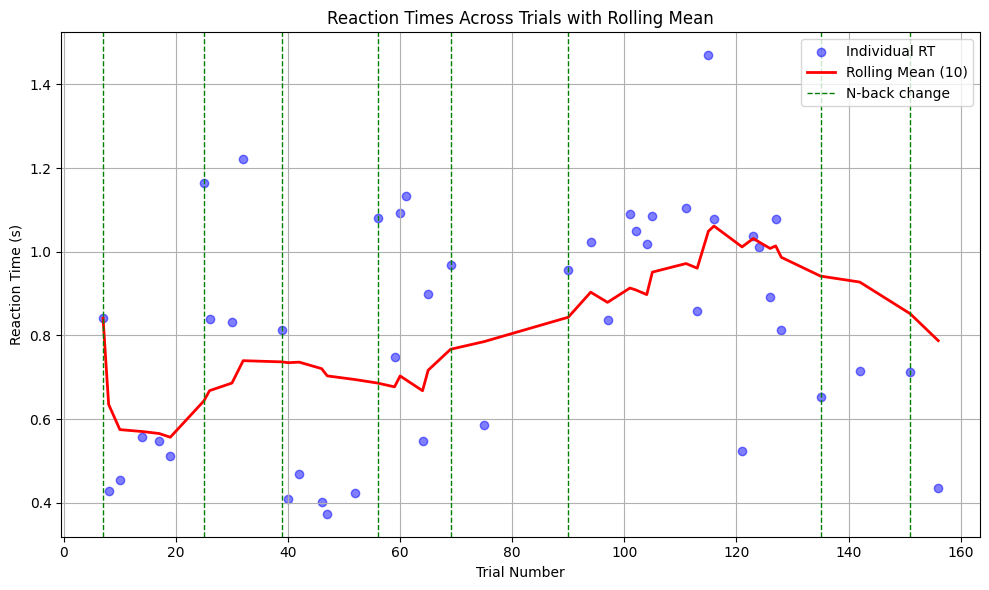

In [2]:
import glob
import os

directory = "C:/Users/tue.vu_pison/Desktop/git/dataops_tools/pison_nback/data"
pattern = "*.csv"
files = glob.glob(os.path.join(directory, pattern))

if files:
    most_recent_file = max(files, key=os.path.getmtime)
    print("Most recent file:", most_recent_file)
    plot_nback_data(most_recent_file, rolling_window=10)
else:
    print("No files found matching the pattern.")

In [ ]:
import os
import glob
import pandas as pd
import numpy as np

# For repeated-measures ANOVA:
from statsmodels.stats.anova import AnovaRM

# ---------------------------------------------------------
# CONFIG: Adjust as necessary
DATA_DIR = "./data"        # The directory where your CSV files are stored
FILENAME_PATTERN = "data_*.csv"  # Pattern for your data files

# If you stored 'Setting' in the CSV (recommended), set USE_CSV_SETTING = True
USE_CSV_SETTING = True
# If you didn't store 'Setting', we will parse from the filename. 
# E.g., "data_P001_session2_setting3.csv" or something similar
# Adjust parse_filename_for_setting() as needed.
# ---------------------------------------------------------


def parse_filename_for_setting(fn):
    """
    If your CSV doesn't contain a 'Setting' column, you can parse it
    from the filename. For example, if your filename is:
         data_P002_setting3.csv
    and the '3' indicates the Setting = "3".
    Here is a simple example that looks for the substring 'setting' and 
    extracts what follows.
    
    Adjust the logic to match your actual naming scheme!
    """
    base = os.path.basename(fn)
    # Example: data_Alice_s1_setting2.csv
    # Let's split by underscores:
    parts = base.replace(".csv", "").split("_")
    
    # We'll look for any part that starts with 'setting' (case-insensitive):
    for p in parts:
        if p.lower().startswith("setting"):
            # e.g. "setting2" -> "2"
            return p.lower().replace("setting", "")
    
    # If your naming is simpler like data_P001_2.csv, you might do:
    # return parts[-1]  # the last chunk is '2'
    
    return None  # fallback if not found


def load_all_data(data_dir=DATA_DIR, pattern=FILENAME_PATTERN):
    """
    Loads and concatenates all CSV files from the specified data directory.
    Returns a single pandas DataFrame.
    """
    all_files = glob.glob(os.path.join(data_dir, pattern))
    df_list = []
    
    for file_path in all_files:
        try:
            temp_df = pd.read_csv(file_path)
            
            # If the CSV does not have 'Setting', parse from filename
            if not USE_CSV_SETTING or 'Setting' not in temp_df.columns:
                setting = parse_filename_for_setting(file_path)
                temp_df['Setting'] = setting
                
            # Also, if your CSV doesn't have a 'Participant ID' column, 
            # you might parse from filename or assign something:
            if 'Participant ID' not in temp_df.columns:
                # E.g., parse from filename:
                # data_P001_setting2.csv -> "P001"
                # This is just an example. Adapt to your real scheme.
                filename_base = os.path.basename(file_path).replace(".csv", "")
                # Potentially parse out "P001" from something
                # We'll do a naive approach:
                parts = filename_base.split("_")
                # Look for something that starts with 'P'
                p_id = 'Unknown'
                for part in parts:
                    if part.upper().startswith("P"):
                        p_id = part
                        break
                temp_df['Participant ID'] = p_id

            df_list.append(temp_df)
        except Exception as e:
            print(f"Could not read file {file_path}, skipping. Error: {e}")
    
    if len(df_list) == 0:
        raise ValueError(f"No CSV files found in {data_dir} with pattern '{pattern}'.")

    df = pd.concat(df_list, ignore_index=True)
    return df


def compute_metrics(df):
    """
    Compute descriptive stats (mean RT, accuracy, etc.)
    grouped by participant, setting.

    Expects columns:
      - 'Participant ID'
      - 'Setting'
      - 'Correct' (boolean)
      - 'RT' (numeric)
    """
    # Convert RT to numeric; drop invalid or missing RTs
    df['RT'] = pd.to_numeric(df['RT'], errors='coerce')
    df = df[df['RT'].notna() & (df['RT'] >= 0)]
    
    # Ensure 'Correct' is boolean
    df['Correct'] = df['Correct'].astype(bool)

    # Group by participant & setting
    grouped = df.groupby(['Participant ID', 'Setting'])

    summary = grouped.agg(
        MeanRT=('RT', 'mean'),
        MedianRT=('RT', 'median'),
        Accuracy=('Correct', 'mean'),
        Trials=('Correct', 'size')
    ).reset_index()
    
    # Convert accuracy to percentage
    summary['Accuracy'] = summary['Accuracy'] * 100.0
    return summary


def run_repeated_measures_anova(df_summary, dv='MeanRT'):
    """
    Runs a repeated-measures ANOVA on 'dv' across settings.
    Returns the fitted model results.
    """
    # Convert Setting to string if needed
    df_summary['Setting'] = df_summary['Setting'].astype(str)

    # Make sure participant column has no spaces:
    df_summary = df_summary.rename(columns={'Participant ID': 'Participant_ID'})

    # Pivot to wide
    pivoted = df_summary.pivot(
        index='Participant_ID',
        columns='Setting',
        values=dv
    )

    # Drop participants who don't have all 4 settings (if needed)
    needed_settings = {'1','2','3','4'}
    pivoted = pivoted.dropna(subset=needed_settings, how='any')

    # Return to long
    pivoted = pivoted.reset_index()
    long_df = pd.melt(
        pivoted,
        id_vars=['Participant_ID'],
        value_vars=['1','2','3','4'],
        var_name='Setting',
        value_name=dv
    )

    # Fit repeated-measures ANOVA
    model = AnovaRM(
        data=long_df, 
        depvar=dv, 
        subject='Participant_ID', 
        within=['Setting']
    )
    results = model.fit()
    print("\nRepeated-Measures ANOVA on", dv)
    print(results.summary())
    
    return results


def main():
    # 1) Load data
    df = load_all_data(DATA_DIR, FILENAME_PATTERN)

    # 2) Compute metrics: mean RT, median RT, accuracy, # of trials
    summary_df = compute_metrics(df)
    print("\n--- DESCRIPTIVE STATS PER PARTICIPANT x SETTING ---")
    print(summary_df.to_string(index=False))

    # 3) If each participant completed all 4 settings, run repeated-measures ANOVA on MeanRT
    anova_rt = run_repeated_measures_anova(summary_df, dv='MeanRT')

    # 4) (Optional) run repeated-measures ANOVA on Accuracy
    anova_acc = run_repeated_measures_anova(summary_df, dv='Accuracy')

    # 5) We can also look at the group means across participants:
    group_stats = summary_df.groupby('Setting').agg(
        MeanOfMeanRT=('MeanRT','mean'),
        StdOfMeanRT=('MeanRT','std'),  # <-- ADDED THIS
        MeanOfAccuracy=('Accuracy','mean'),
        StdOfAccuracy=('Accuracy','std')  # <-- ADDED THIS (optional)
        ).reset_index()

    print("\n--- AVERAGE (ACROSS PARTICIPANTS) MEAN RT AND ACCURACY (WITH SD) BY SETTING ---")
    print(group_stats.to_string(index=False))

    # ----------------------------------------------------
    # Write results to a text file
    # ----------------------------------------------------
    output_filename = "analysis_results.txt"
    with open(output_filename, "w", encoding="utf-8") as out_file:
        out_file.write("=== N-Back Analysis Results ===\n\n")

        # 1) Descriptive Stats
        out_file.write("--- DESCRIPTIVE STATS PER PARTICIPANT x SETTING ---\n")
        out_file.write(summary_df.to_string(index=False))
        out_file.write("\n\n")

        # 2) ANOVA on MeanRT
        out_file.write("=== Repeated-Measures ANOVA on MeanRT ===\n")
        out_file.write(anova_rt.summary().as_text())
        out_file.write("\n\n")

        # 3) ANOVA on Accuracy
        out_file.write("=== Repeated-Measures ANOVA on Accuracy ===\n")
        out_file.write(anova_acc.summary().as_text())
        out_file.write("\n\n")

        # 4) Group Means
        out_file.write("--- AVERAGE (ACROSS PARTICIPANTS) MEAN RT AND ACCURACY BY SETTING ---\n")
        out_file.write(group_means.to_string(index=False))
        out_file.write("\n")



    print(f"\nAll results have been written to {output_filename}.")


if __name__ == "__main__":
    main()



--- DESCRIPTIVE STATS PER PARTICIPANT x SETTING ---
Participant ID  Setting   MeanRT  MedianRT  Accuracy  Trials
       Unknown        1 0.519347  0.458796 91.111111      45
       Unknown        2 0.479971  0.435846 93.333333      45
       Unknown        3 0.503177  0.432524 92.000000      50
       Unknown        4 0.460315  0.429413 93.617021      47

Repeated-Measures ANOVA on MeanRT
               Anova
        F Value Num DF Den DF Pr > F
------------------------------------
Setting  0.0000 3.0000 0.0000    nan


Repeated-Measures ANOVA on Accuracy
               Anova
        F Value Num DF Den DF Pr > F
------------------------------------
Setting  0.0000 3.0000 0.0000    nan


--- AVERAGE (ACROSS PARTICIPANTS) MEAN RT AND ACCURACY BY SETTING ---
Setting  MeanOfMeanRT  MeanOfAccuracy
      1      0.519347       91.111111
      2      0.479971       93.333333
      3      0.503177       92.000000
      4      0.460315       93.617021

All results have been written to analysis_

C:\Users\tue.vu_pison\AppData\Local\Temp\ipykernel_13596\2242114492.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Correct'] = df['Correct'].astype(bool)
C:\Users\tue.vu_pison\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\stats\anova.py:598: RuntimeWarning: divide by zero encountered in scalar divide
  mse = ssr / df_resid
C:\Users\tue.vu_pison\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\stats\anova.py:598: RuntimeWarning: divide by zero encountered in scalar divide
  mse = ssr / df_resid
